In [43]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device", device)

# load model (确保模型加载时输出注意力)
model_path = "./save_model/task1_roberta-large_template0"
model = RobertaForSequenceClassification.from_pretrained(
    model_path,
    output_attentions=True
)
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model.to(device)
print("Using model", model_path)

# 选择prompt模板
prompt_templates = [
    "{Sent1} <sep> {Sent2}",
    "{Sent1} is more reasonable than {Sent2}",
    "Which is in common sense {Sent1} or {Sent2}",
]
template = prompt_templates[0]
print("Using prompt template:", template)

# 预处理测试数据
test_dataset = utils.preprocess_task1("./ALL data/test.csv", tokenizer, template, sep_token="</s>",
                                      is_random=False, padding=False)

Using device cuda
Using model ./save_model/task1_roberta-large_template0
Using prompt template: {Sent1} <sep> {Sent2}


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

['<s>', 'cake', 'is', 'not', 'poisonous', '', '</s>', 'lead', 'is', 'not', 'poisonous', '</s>']
['<s>', 'cake', 'is', 'not', 'poisonous', '</s>', 'lead', 'is', 'not', 'poisonous', '</s>']


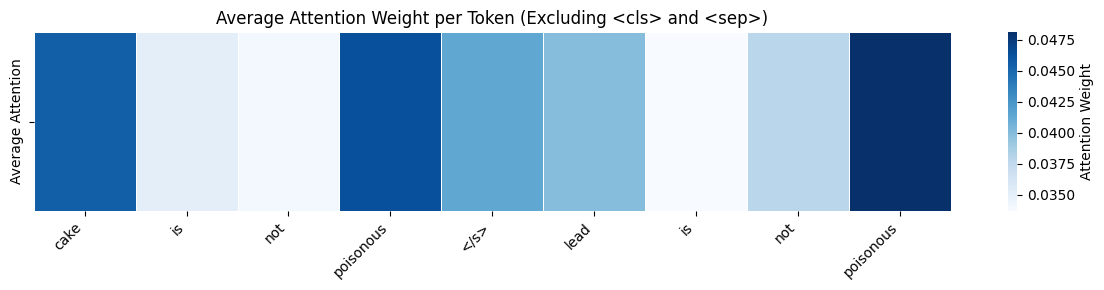

1


In [99]:
# 选择要可视化的样本索引
sample_idx = 139
sample = test_dataset[sample_idx]
input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_ids)
    
attentions = outputs.attentions 
attentions = [attn.cpu().numpy() for attn in attentions]
stacked_attentions = np.stack(attentions, axis=0)
stacked_attentions = stacked_attentions[:, 0, :, :, :]

# 计算所有层和所有头的平均注意力
mean_attention = np.mean(stacked_attentions, axis=(0, 1))  # (seq_len, seq_len)

# 按列平均得到每个词的平均注意力向量
mean_attention_vector = np.mean(mean_attention, axis=0)  # (seq_len,)

# 获取token文本
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

for i in range(2, len(tokens)):
    if tokens[i] == "</s>":
        continue
    tokens[i] = tokens[i][1:]
print(tokens)
    
filtered_tokens, filtered_weights = zip(*[
    (token, weight) 
    for token, weight in zip(tokens, mean_attention_vector) 
    if token != ""
])

tokens = list(filtered_tokens)
weights = np.array(filtered_weights)
print(tokens)


# 移除<cls>和<eos>
tokens_filtered1 = tokens[1:-1]
mean_attention_vector_filtered1 = weights[1:-1]

# 绘制热力图
plt.figure(figsize=(12, 3))
sns.heatmap(mean_attention_vector_filtered1.reshape(1, -1),
            xticklabels=tokens_filtered1,
            yticklabels=["Average Attention"],
            cmap='Blues',
            square=False,
            linewidths=.5,
            cbar_kws={'label': 'Attention Weight'})
plt.title('Average Attention Weight per Token (Excluding <cls> and <sep>)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

with torch.no_grad():
    pred_a = torch.argmax(outputs.logits).item()
print(pred_a)

In [100]:
# load model (确保模型加载时输出注意力)
model_path2 = "./save_model/task1_roberta-large_template1"
model2 = RobertaForSequenceClassification.from_pretrained(
    model_path,
    output_attentions=True 
)
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model2.to(device)
print("Using model", model_path2)

# 选择prompt模板
prompt_templates = [
    "{Sent1} <sep> {Sent2}",
    "{Sent1} is more reasonable than {Sent2}",
    "Which is in common sense {Sent1} or {Sent2}",
]
template = prompt_templates[1]
print("Using prompt template:", template)

# 预处理测试数据
test_dataset2 = utils.preprocess_task1("./ALL data/test.csv", tokenizer, template, is_random=False, sep_token="</s>", padding=False)

Using model ./save_model/task1_roberta-large_template1
Using prompt template: {Sent1} is more reasonable than {Sent2}


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

['<s>', 'cake', 'is', 'not', 'poisonous', 'is', 'more', 'reasonable', 'than', 'lead', 'is', 'not', 'poisonous', '</s>']


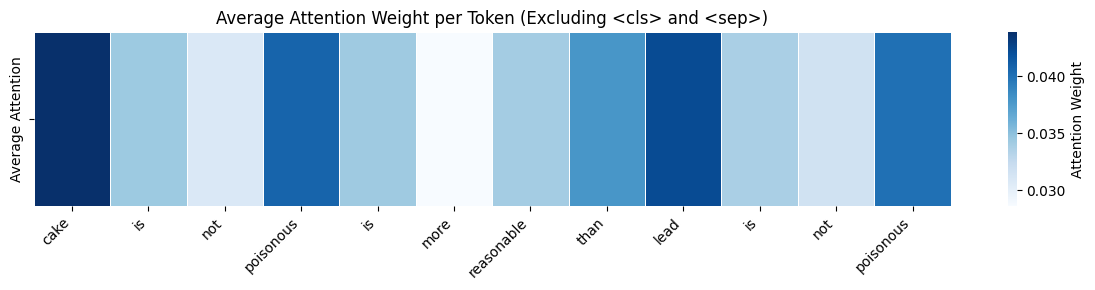

1


In [101]:
sample = test_dataset2[sample_idx]
input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model2(input_ids)

attentions = outputs.attentions
attentions = [attn.cpu().numpy() for attn in attentions]
stacked_attentions = np.stack(attentions, axis=0)
stacked_attentions = stacked_attentions[:, 0, :, :, :]

mean_attention = np.mean(stacked_attentions, axis=(0, 1)) 

mean_attention_vector = np.mean(mean_attention, axis=0)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
for i in range(2, len(tokens)):
    if tokens[i] == "</s>":
        continue
    tokens[i] = tokens[i][1:]
    
filtered_tokens, filtered_weights = zip(*[
    (token, weight) 
    for token, weight in zip(tokens, mean_attention_vector) 
    if token != ""
])

tokens = list(filtered_tokens)
weights = np.array(filtered_weights)
print(tokens)

tokens_filtered2 = tokens[1:-1]
mean_attention_vector_filtered2 = weights[1:-1]

plt.figure(figsize=(12, 3))
sns.heatmap(mean_attention_vector_filtered2.reshape(1, -1),
            xticklabels=tokens_filtered2,
            yticklabels=["Average Attention"],
            cmap='Blues',
            square=False,
            linewidths=.5,
            cbar_kws={'label': 'Attention Weight'})
plt.title('Average Attention Weight per Token (Excluding <cls> and <sep>)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

with torch.no_grad():
    pred_b = torch.argmax(outputs.logits).item()
print(pred_b)

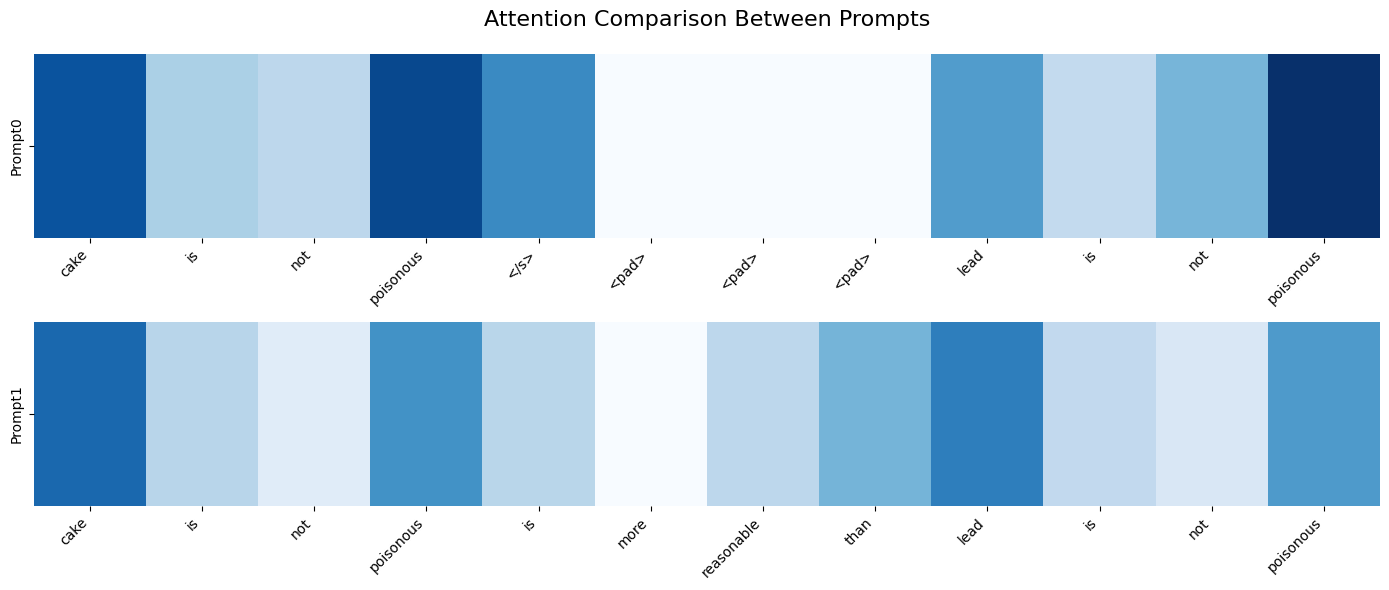

In [109]:
sep_pos = tokens_filtered1.index("</s>")

vmin = min(np.min(mean_attention_vector_filtered1), np.min(mean_attention_vector_filtered2))
vmax = max(np.max(mean_attention_vector_filtered1), np.max(mean_attention_vector_filtered2))

num_extra_tokens = len(tokens_filtered2) - len(tokens_filtered1)

attention_vec_padded = np.insert(
    mean_attention_vector_filtered1,
    sep_pos + 1, 
    [0] * num_extra_tokens  
)

tokens_padded = (
    tokens_filtered1[:sep_pos + 1]  
    + ["<pad>"] * num_extra_tokens 
    + tokens_filtered1[sep_pos + 1:]  
)

# 创建画布
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=False)

# 绘制第一个prompt的热力图
sns.heatmap(attention_vec_padded.reshape(1, -1),
            ax=ax1,
            xticklabels=tokens_padded,
            yticklabels=["Prompt0"],
            cmap="Blues",
            cbar=False,
            square=False,
            # annot=True,
            vmin=vmin,
            vmax=vmax,
            fmt=".2f")

# 绘制第二个prompt的热力图
sns.heatmap(mean_attention_vector_filtered2.reshape(1, -1),
            ax=ax2,
            xticklabels=tokens_filtered2,
            yticklabels=["Prompt1"],
            cmap="Blues",
            cbar=False,
            square=False,
            # annot=True,
            vmin=vmin,
            vmax=vmax,
            fmt=".2f")

# # 添加公共colorbar
# cbar = fig.colorbar(ax2.collections[0], ax=[ax1, ax2], location='right', pad=0.02)
# cbar.set_label('Attention Weight')

# 调整布局
ax1.set_title("Attention Comparison Between Prompts", fontsize=16, pad=20)
ax1.set_xticklabels(tokens_padded, rotation=45, ha='right')
ax2.set_xticklabels(tokens_filtered2, rotation=45, ha='right')
plt.tight_layout()
plt.savefig("./plots/Attention.png")
plt.show()


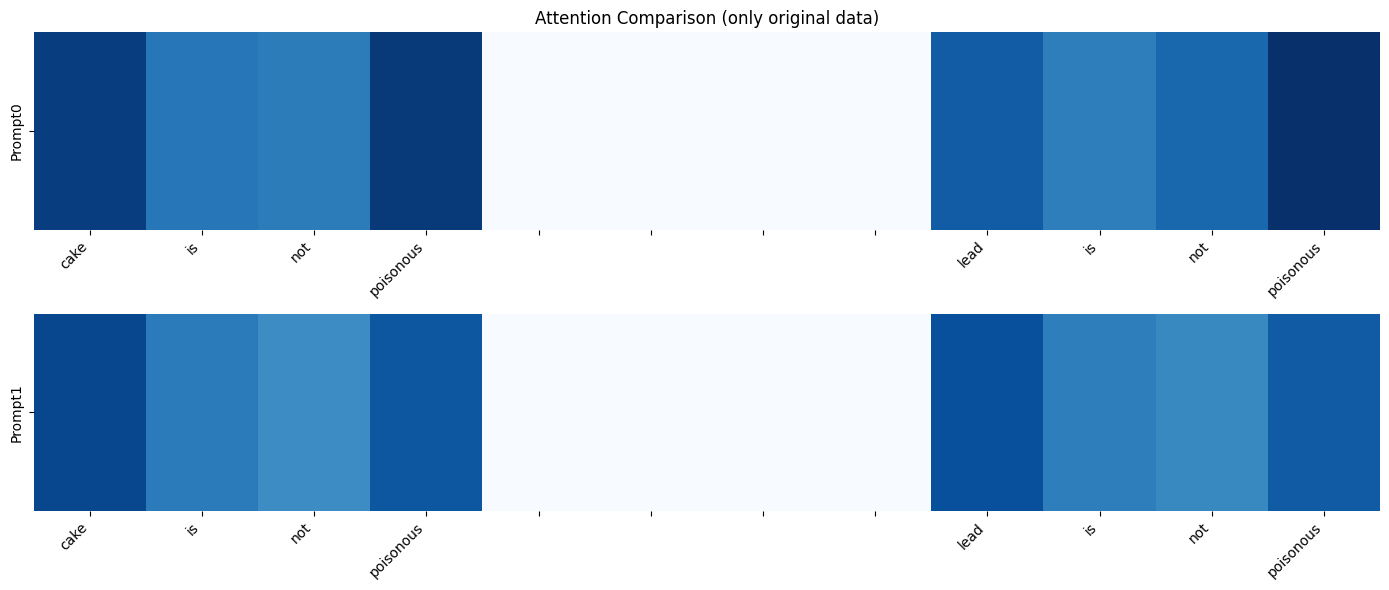

In [52]:
# 去除所有中间词

sep_pos = tokens_filtered1.index("</s>")
mean_attention_vector_filtered1[sep_pos-1:sep_pos+1] = 0.0
mean_attention_vector_filtered2[sep_pos-1: sep_pos+3] = 0.0

vmin = min(np.min(mean_attention_vector_filtered1), np.min(mean_attention_vector_filtered2))
vmax = max(np.max(mean_attention_vector_filtered1), np.max(mean_attention_vector_filtered2))

num_extra_tokens = len(tokens_filtered2) - len(tokens_filtered1)

attention_vec_padded = np.insert(
    mean_attention_vector_filtered1,
    sep_pos + 1,  # 在 `<sep>` 后插入
    [0] * num_extra_tokens  
)

tokens_padded = (
    tokens_filtered1[:sep_pos + 1]  
    + [""] * num_extra_tokens 
    + tokens_filtered1[sep_pos + 1:]  
)
for i in range(sep_pos-1, sep_pos+3):
    tokens_padded[i] = ""
    tokens_filtered2[i] = ""

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))

sns.heatmap(
    attention_vec_padded.reshape(1, -1),
    ax=ax1,
    xticklabels=tokens_padded,
    yticklabels=["Prompt0"],
    cmap="Blues",
    square=False,
    cbar=False,
    # annot=True,
    fmt=".3f",
    vmin=vmin,
    vmax=vmax,
)

# 绘制 Prompt2（原始）
sns.heatmap(
    mean_attention_vector_filtered2.reshape(1, -1),
    ax=ax2,
    xticklabels=tokens_filtered2,
    yticklabels=["Prompt1"],
    cmap="Blues",
    square=False,
    cbar=False,
    # annot=True,
    fmt=".3f",
    vmin=vmin,
    vmax=vmax,
)

# 调整布局
ax1.set_title("Attention Comparison (only original data)")
ax1.set_xticklabels(tokens_padded, rotation=45, ha="right")
ax2.set_xticklabels(tokens_filtered2, rotation=45, ha="right")
plt.tight_layout()
plt.show()